## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [82]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
%matplotlib qt
%matplotlib inline

## 1. Evaluate functions on test images

### 1.1 First, I'll compute the camera calibration using chessboard images

C:\UDACITY\SelfDrivingCar_Nanodegree\Term1\CarND-Advanced-Lane-Lines-master\camera_cal\calibration1.jpg


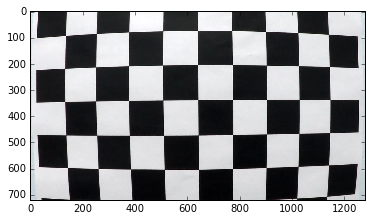

In [83]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob(os.getcwd() + '\camera_cal\calibration*.jpg')
print(images[0])
# print first image
img1 = cv2.imread(images[0])
plt.imshow(img1)

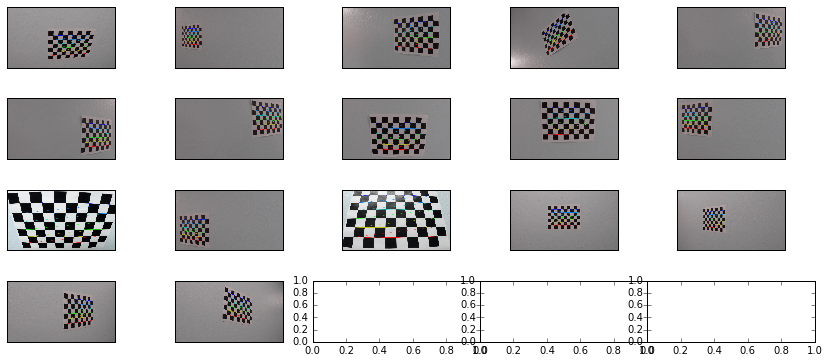

In [84]:
# Step through the list and search for chessboard corners
fig, axs = plt.subplots(4,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
i = 0
for fname in images:
    img = cv2.imread(fname)
    #plt.imshow(img)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #plt.imshow(img)
        axs[i].imshow(img)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        i=i+1
        #cv2.waitKey(500)
        
#cv2.destroyAllWindows()

###  1.2 Camera calibration

In [85]:
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y
# calibrate the camera using the cv2.calibrateCamera function:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

Example from the lesson to unwarp the chessboard:

In [86]:
def corners_unwarp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # 2) Convert to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    img_size = (gray.shape[1], gray.shape[0])
    # 4) If corners found: 
    offset = 100
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    # 4) If corners found: 
    ret = True
    if ret == True:
        imgpoints.append(corners)
        img_size = (gray.shape[1], gray.shape[0])
        offset = 100
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undist, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
        
    return warped, M

Visualization of the chessboard example:

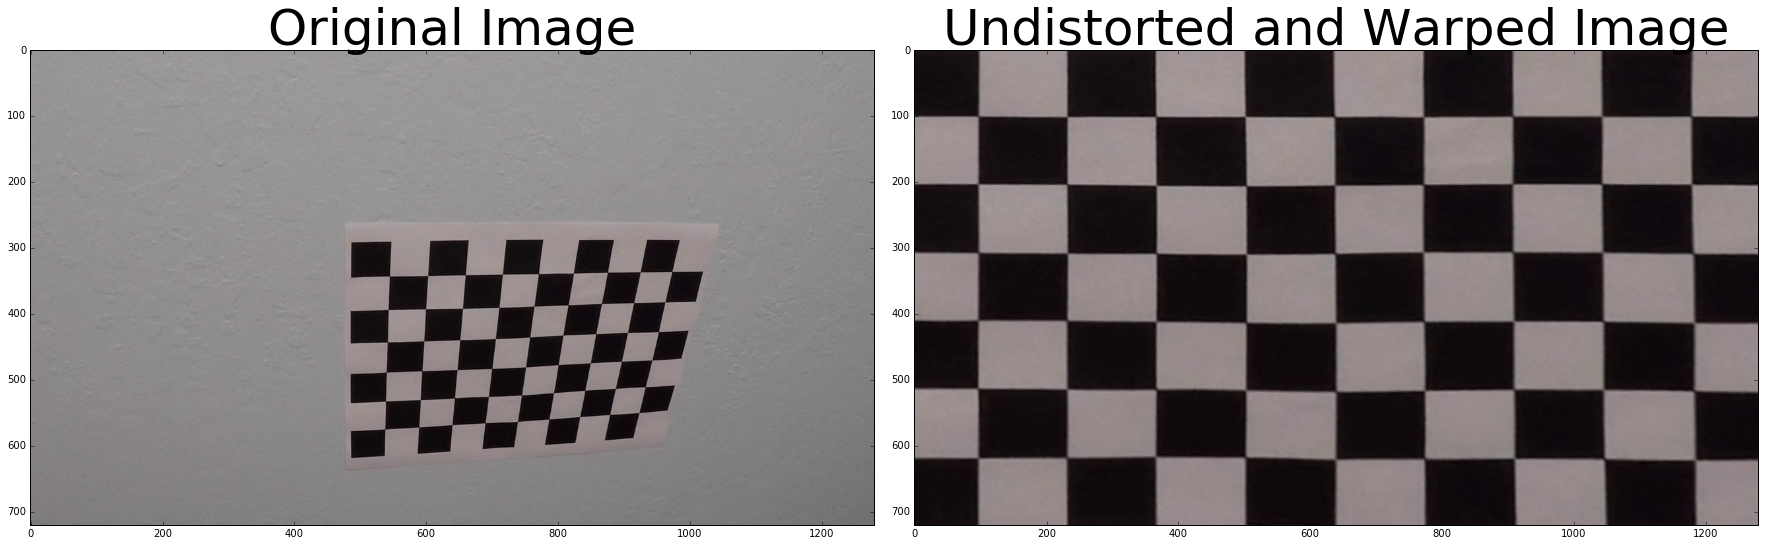

In [87]:
img = cv2.imread(images[1])
top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

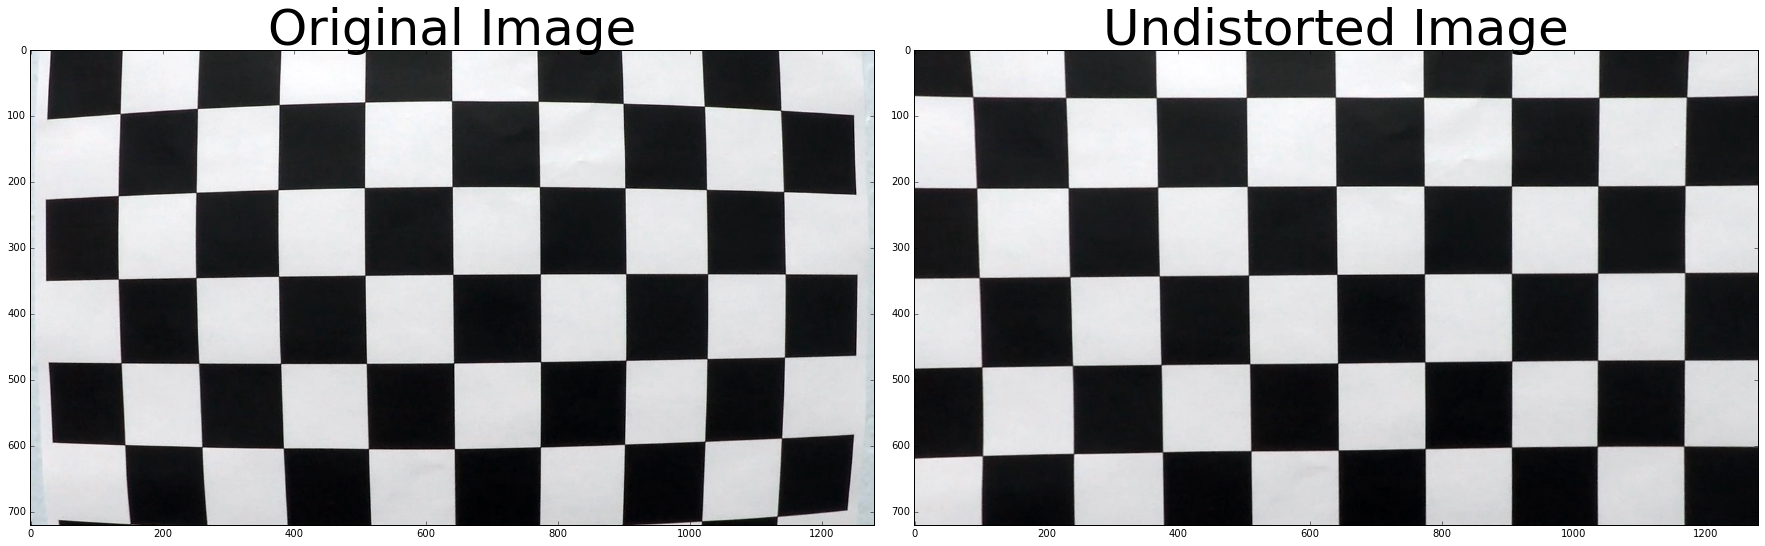

In [88]:
img = cv2.imread(images[0])

undist2 = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist2)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


### 1.3 Applying lane finding steps to vehicle test images

#### Image distortion:

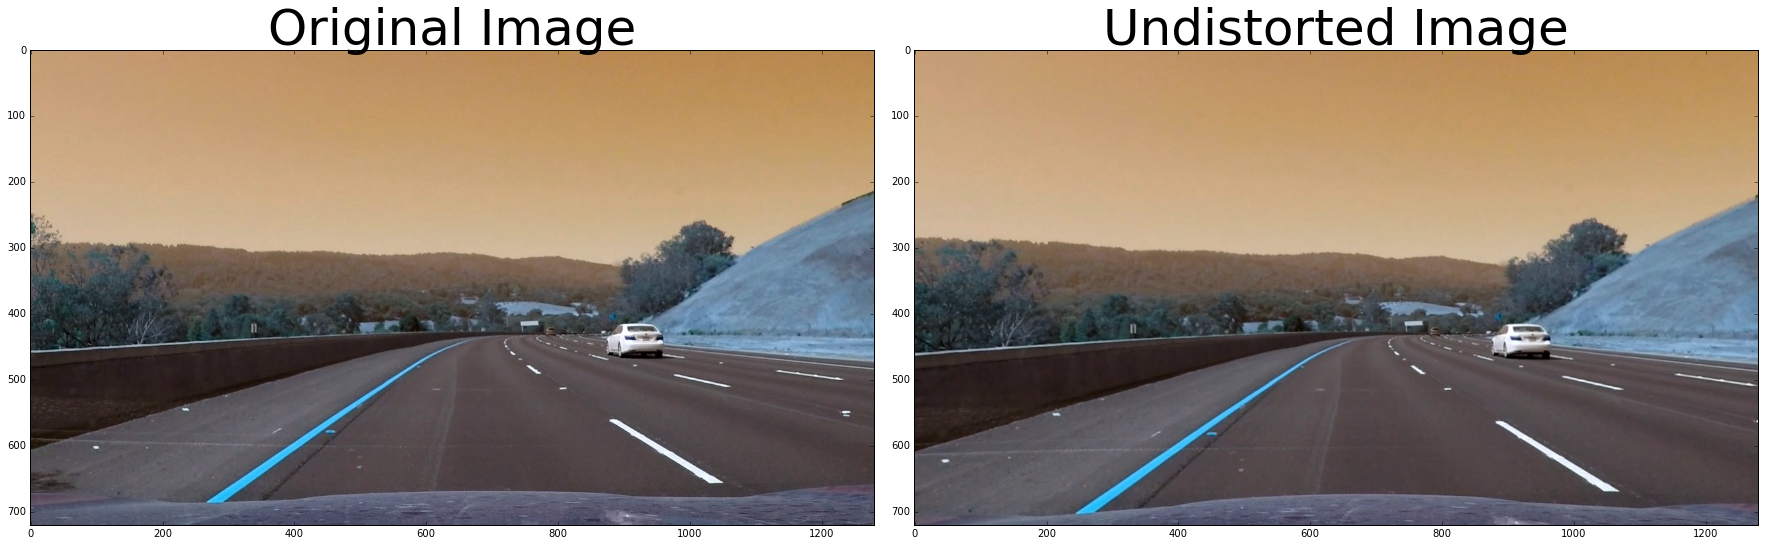

In [89]:
img2 = cv2.imread(os.getcwd() + '\\test_images\\test3.jpg')
#cv2.imshow('img2', img2)
if img2.shape[0] != 720:
    img2 = cv2.resize(img2,(1280, 720), interpolation = cv2.INTER_CUBIC)


undist_test = cv2.undistort(img2, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img2)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist_test)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### 1.4 Apply Sobel Operator to test image

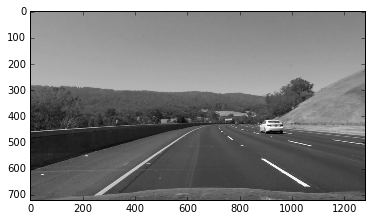

In [90]:
# grayscale the image
img_gray_test = cv2.cvtColor(undist_test, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray_test, cmap="gray")

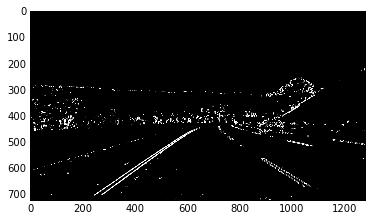

In [91]:
# getting Sobel Operators for x and y axis
kernelSize = 5

sobelx = cv2.Sobel(img_gray_test, cv2.CV_64F, 1, 0, ksize = kernelSize)
sobely = cv2.Sobel(img_gray_test, cv2.CV_64F, 0, 1, ksize = kernelSize)
# calculate absolute value of sobel x 
# Gradient in x-axis is more important to detect the lane lines through the histograms
abs_sobelx = np.absolute(sobelx)
#abs_sobelx = np.sqrt(sobelx**2 + sobely**2)
# convert to 8bit
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
# binary thresholds
thresh_min = 25 #was 50 for images with sunlight
thresh_max = 100 #was 100
# applying the thresholds
sxbinary_test = np.zeros_like(scaled_sobel)
sxbinary_test[(scaled_sobel > thresh_min) & (scaled_sobel <= thresh_max)] = 1
plt.imshow(sxbinary_test, cmap="gray")

### 1.5 Convert to HLS color-space

In [92]:
# convert to hls
hls_test = cv2.cvtColor(undist_test, cv2.COLOR_RGB2HLS)
s_chan_test = hls_test[:,:,2]

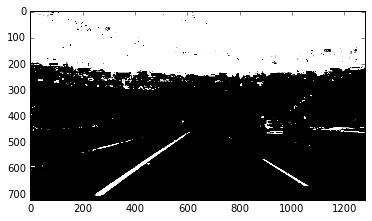

In [93]:
# setting color thresholds and apply them to the test image
s_thresh_min_test = 100  #was 100
s_thresh_max_test = 255 #was 255
s_binary_test = np.zeros_like(s_chan_test)
s_binary_test[(s_chan_test > s_thresh_min_test) & (s_chan_test <= s_thresh_max_test)] = 1
plt.imshow(s_binary_test, cmap="gray")

### 1.6 Stack the filters

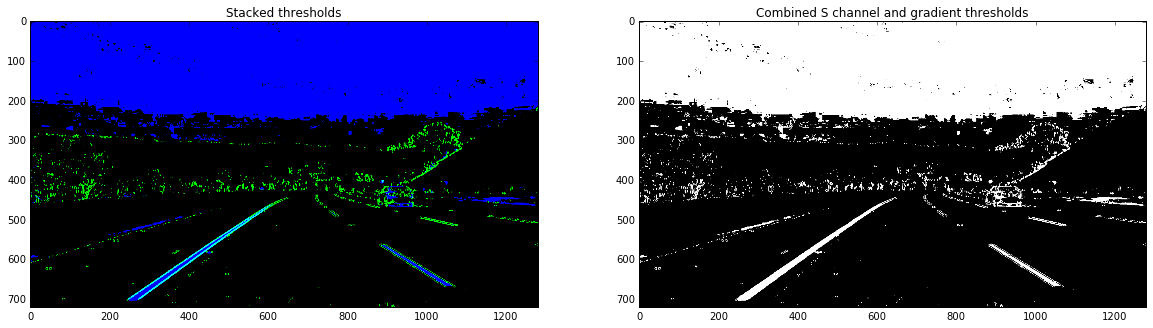

In [94]:
color_binary_test = np.dstack((np.zeros_like(sxbinary_test), sxbinary_test, s_binary_test))*255
# combine them
comb_binary_test = np.zeros_like(sxbinary_test)
comb_binary_test[(s_binary_test == 1) | (sxbinary_test == 1)] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary_test)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(comb_binary_test, cmap='gray')

### 1.7 warp the perspective

m1: -0.6829268292682927
m2: 0.6086956521739131


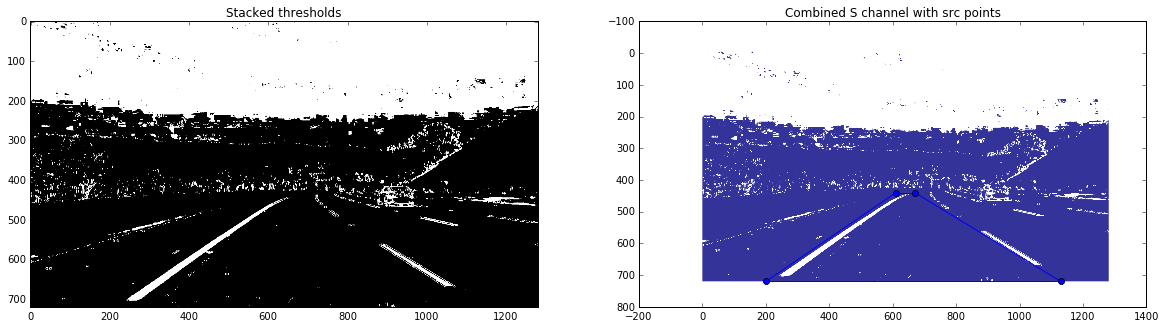

In [95]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(comb_binary_test, cmap="gray")
ax2.set_title('Combined S channel with src points')
ax2.imshow(comb_binary_test, cmap='terrain')

light = "light"
x1 = 200 # 200
y1 = 720
x2 = 610 #was 560
y2 = 440 #was 470
x3 = 670 #720
y3 = 440 #was 470
x4 = 1130 #1080
y4 = 720
#src = np.float32([[720, 470], [1100, 720], [200, 720], [560, 470]])
if light == "dark":
    x1 = 260 # 200
    y1 = 720
    x2 = 600 #was 560
    y2 = 480 #was 470
    x3 = 700 #720
    y3 = 480 #was 470
    x4 = 1100 #1080
    y4 = 720 

ax2.plot([x1, x2], [y1, y2], marker = 'o', color="blue")
ax2.plot([x2, x3], [y2, y3], marker = 'o', color="blue")
ax2.plot([x3, x4], [y3, y4], marker = 'o', color="blue")
ax2.plot([x4, x1], [y1, y4], marker = 'o', color="blue")

print("m1: {}".format((y2-y1)/(x2-x1)))
print("m2: {}".format((y3-y4)/(x3-x4)))


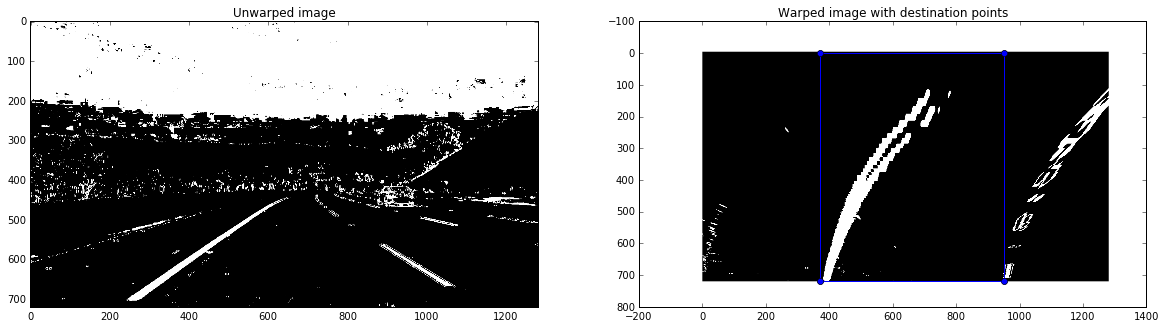

In [96]:
# top right first
#src = np.float32([[720, 470], [1100, 720], [200, 720], [560, 470]])

src = np.float32([[x3, y3], [x4, y4], [x1, y1], [x2, y2]])
dst = np.float32([[950, 0], [950, 720], [370, 720], [370, 0]])

img_size_test = (comb_binary_test.shape[1], comb_binary_test.shape[0])

M_test = cv2.getPerspectiveTransform(src, dst)
Minv_test = cv2.getPerspectiveTransform(dst, src)
img_warped_test = cv2.warpPerspective(comb_binary_test, M_test, img_size_test, flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Unwarped image')
ax1.imshow(comb_binary_test, cmap="gray")
ax2.set_title('Warped image with destination points')
ax2.imshow(img_warped_test, cmap='gray')
ax2.plot([370, 370], [720, 0], marker = 'o', color="blue")
ax2.plot([370, 950], [0, 0], marker = 'o', color="blue")
ax2.plot([950, 950], [0, 720], marker = 'o', color="blue")
ax2.plot([950, 370], [720, 720], marker = 'o', color="blue")

### 1.8 region of interest

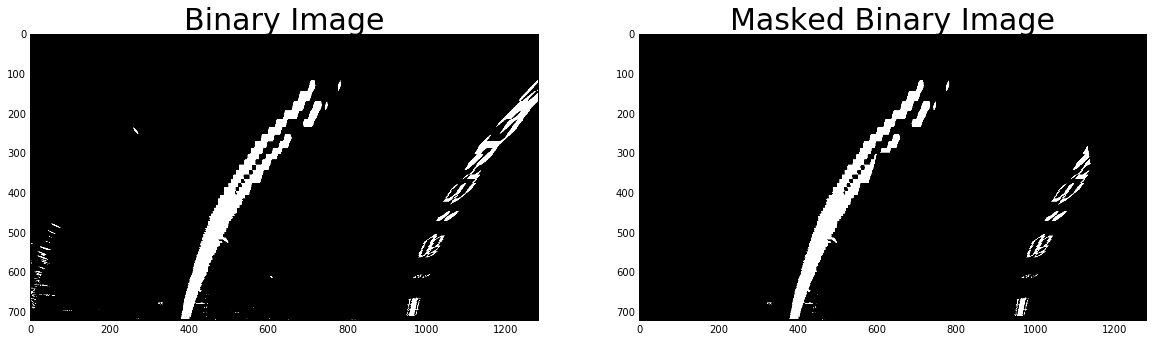

In [97]:
mask = np.zeros_like(img_warped_test) 
#defining a 3 channel or 1 channel color to fill the mask with depending on the input image
ignore_mask_color = 255   
#vertices = np.array([[(200, 720),(280, 0), (1100, 0), (1050,720)]], dtype=np.int32)
vertices = np.array([[(300, 720),(300, 100), (1100, 100), (1200,720)]], dtype=np.int32)
vertices2 = np.array([[(500, 720),(600, 300), (800, 300), (900,720)]], dtype=np.int32)
#filling pixels inside the polygon defined by "vertices" with the fill color    
cv2.fillPoly(mask, vertices, ignore_mask_color)
cv2.fillPoly(mask, vertices2, 0)

#returning the image only where mask pixels are nonzero
masked_image_test = cv2.bitwise_and(img_warped_test, mask)
#masked_image_test = cv2.bitwise_and(img_warped_test, mask)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_warped_test, cmap='gray')
ax1.set_title('Binary Image', fontsize=30)
ax2.imshow(masked_image_test, cmap='gray')
ax2.set_title('Masked Binary Image', fontsize=30)



### 1.9 find lane lines with histograms

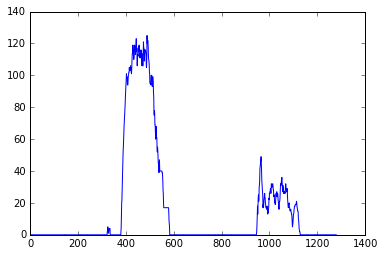

In [98]:
histogram_test = np.sum(masked_image_test[masked_image_test.shape[0]//2:,:], axis=0)
plt.plot(histogram_test)

In [99]:
## set the points for left and right lane
out_img_test = np.dstack((img_warped_test, img_warped_test, img_warped_test))*255
midpoint_test = np.int(histogram_test.shape[0]/2)
offset_shadow = 0

leftx_base_test = np.argmax(histogram_test[:midpoint_test])
rightx_base_test = np.argmax(histogram_test[midpoint_test:])+midpoint_test
print("mid: {}  left: {}  right: {}".format(midpoint_test, leftx_base_test, rightx_base_test))
detected_left = False
detected_right = False
if (leftx_base_test > 300) & (leftx_base_test < 500):
    detected_left = True
if (rightx_base_test > 800) & (rightx_base_test < 1000):
    detected_right = True
if detected_left == False:
    leftx_base_test = np.argmax(histogram_test[:midpoint_test-offset_shadow])
if detected_right == False:
    rightx_base_test = np.argmax(histogram_test[midpoint_test+offset_shadow:])+midpoint_test
print("mid: {}  left: {}  right: {}".format(midpoint_test, leftx_base_test, rightx_base_test))

mid: 640  left: 488  right: 965
mid: 640  left: 488  right: 965


### 1.10 implementing sliding windows and fit a polynomial 

In [100]:
nwindows = 9
img_warped_test = masked_image_test
window_height = np.int(img_warped_test.shape[0]/nwindows) 
# indices of non zero elements
nonzero = img_warped_test.nonzero()

nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# initial window position
leftx_current = leftx_base_test
rightx_current = rightx_base_test

margin = 100
minpix = 50

left_lane_inds = []
right_lane_inds = []

# loop over windows
for window in range(nwindows):
    win_y_low = img_warped_test.shape[0] - (window + 1) * window_height
    win_y_high = img_warped_test.shape[0] - window * window_height
    win_x_left_low = leftx_current - margin
    win_x_left_high = leftx_current + margin
    win_x_right_low = rightx_current - margin
    win_x_right_high = rightx_current + margin
    cv2.rectangle(out_img_test, (win_x_left_low, win_y_low),(win_x_left_high, win_y_high), (0, 255, 0), 2)
    cv2.rectangle(out_img_test, (win_x_right_low, win_y_low),(win_x_right_high, win_y_high), (0, 255, 0), 2)
    
    # identify non zero pixels in window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_x_left_low) &
                      (nonzerox < win_x_left_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_x_right_low) &
                      (nonzerox < win_x_right_high)).nonzero()[0]
    
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    if (len(good_left_inds) > minpix) & (len(good_right_inds) > minpix):
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        


(720, 0)

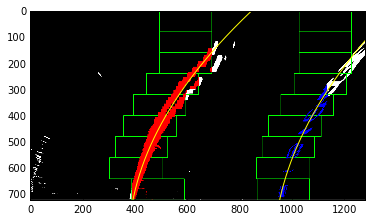

In [101]:
# concatenate found lane indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# extract the pixel positions

left_x = nonzerox[left_lane_inds]
left_y = nonzeroy[left_lane_inds]
right_x = nonzerox[right_lane_inds]
right_y = nonzeroy[right_lane_inds]

# fit second order polynomial
left_fit = np.polyfit(left_y, left_x, 2)
right_fit = np.polyfit(right_y, right_x, 2)

# Visualize sliding windows
ploty = np.linspace(0, img_warped_test.shape[0]-1, img_warped_test.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1] * ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1] * ploty + right_fit[2]

out_img_test[left_y, left_x] = [255, 0, 0]
out_img_test[right_y, right_x] = [0, 0, 255]

plt.imshow(out_img_test)
plt.plot(left_fitx, ploty, color="yellow")
plt.plot(right_fitx, ploty, color="yellow")
plt.xlim(0, 1280)
plt.ylim(720, 0)

### 1.11 skip the sliding search for next frame and search only in margin area

In [102]:
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# use same image for testing purpose again
test_img = np.dstack((img_warped_test, img_warped_test, img_warped_test))*255

left_lane_inds =((nonzerox > (left_fit[0] * (nonzeroy**2) + left_fit[1] * nonzeroy + left_fit[2] - margin)) & 
                 (nonzerox < (left_fit[0] * (nonzeroy**2) + left_fit[1] * nonzeroy + left_fit[2] + margin)))
right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy**2) + right_fit[1] * nonzeroy + right_fit[2] - margin))
                  & (nonzerox < (right_fit[0] * (nonzeroy**2) + right_fit[1] * nonzeroy + right_fit[2] + margin)))

# extract again the pixel positions
left_x = nonzerox[left_lane_inds]
left_y = nonzeroy[left_lane_inds]
right_x = nonzerox[right_lane_inds]
right_y = nonzeroy[right_lane_inds]

left_fit = np.polyfit(left_y, left_x, 2)
right_fit = np.polyfit(right_y, right_x, 2)

left_fitx = left_fit[0]*(ploty**2) + left_fit[1] * ploty + left_fit[2]
right_fitx = right_fit[0]*(ploty**2) + right_fit[1] * ploty + right_fit[2]


(720, 0)

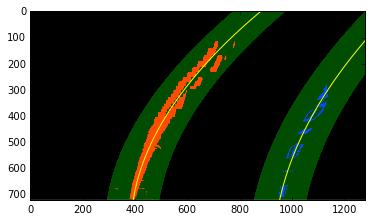

In [103]:
# Visualization
window_img_test = np.zeros_like(test_img)
test_img[left_y, left_x] = [255, 0, 0]
test_img[right_y, right_x] = [0, 0 , 255]

# Generate polygon & illustrate search like in the lesson
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))

right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

cv2.fillPoly(window_img_test, np.int_([left_line_pts]), (0, 255, 0))
cv2.fillPoly(window_img_test, np.int_([right_line_pts]), (0, 255, 0))

result_test = cv2.addWeighted(test_img, 1, window_img_test, 0.3, 0)
plt.imshow(result_test)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### 1.12 calculate curvature

In [104]:
y_eval_test = np.max(ploty)

left_curverad = ((1 + (2 * left_fit[0] * y_eval_test + left_fit[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit[0])
right_curverad = ((1 + (2 * right_fit[0] * y_eval_test + right_fit[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit[0])

print("left curvature: {}  right curvature: {}".format(left_curverad, right_curverad))

left curvature: 730.4571949167813  right curvature: 1029.211520028985


In [105]:
# convert pixels to meters
# assumptions

lane_length = 30
lane_width = 3.7

ym_per_pix = 30/720
xm_per_pix = 3.7/580 #3.7/700

#leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
#rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

left_fit_cr = np.polyfit(left_y * ym_per_pix, left_x * xm_per_pix, 2)
right_fit_cr = np.polyfit(right_y * ym_per_pix, right_x * xm_per_pix, 2)

left_curverad_cr = ((1 + (2 * left_fit_cr[0] * y_eval_test + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit_cr[0])
right_curverad_cr = ((1 + (2 * right_fit_cr[0] * y_eval_test + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit_cr[0])

radius_of_curvature = np.mean([left_curverad_cr, right_curverad_cr])

print("left curvature: {} m;  right curvature: {} m;  mean: {} m".format(left_curverad_cr, right_curverad_cr,
                                                                    radius_of_curvature))

left curvature: 9828.375977812657 m;  right curvature: 5682.228415218831 m;  mean: 7755.302196515744 m


In [106]:
# vehicle position from line
left_pos = (midpoint_test - leftx_base_test) * xm_per_pix
right_pos = (rightx_base_test - midpoint_test) * xm_per_pix
line_base_pos = np.min([left_pos, right_pos])
print("distance from mid: ", line_base_pos)

distance from mid:  0.969655172414


### 1.13 Project found lane lines back to road image

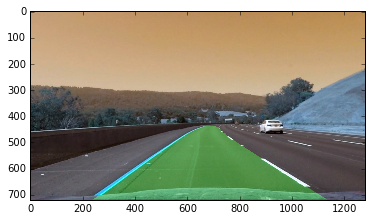

In [107]:
warp_zero_test = np.zeros_like(img_warped_test).astype(np.uint8)
color_warp_test = np.dstack((warp_zero_test, warp_zero_test, warp_zero_test))

# recast the points
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# draw the lane
cv2.fillPoly(color_warp_test, np.int_([pts]), (0, 255, 0))

# warp back to original image
newwarp_test = cv2.warpPerspective(color_warp_test, Minv_test, (img2.shape[1], img2.shape[0]))

result_test = cv2.addWeighted(undist_test, 1, newwarp_test, 0.3, 0)

plt.imshow(result_test,cmap="gray")

## 2. Building the pipeline:

In [108]:
def undistort_img(img, mtx, dist):
    img_undist = cv2.undistort(img, mtx, dist, None, mtx)
    return img_undist

def grayscale(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img_gray

def SobelOp(img, kernelSize, thresh_min, thresh_max):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = kernelSize)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = kernelSize)
    # calculate absolute value of sobel x 
    # Gradient in x-axis is more important to detect the lane lines through the histograms
    abs_sobelx = np.absolute(sobelx)
    # convert to 8bit
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # applying the thresholds
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel > thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return scaled_sobel, sxbinary

def HLSconv(img, s_thresh_min, s_thresh_max):
    # convert to hls
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_chan = hls[:,:,2]
    s_binary = np.zeros_like(s_chan)
    s_binary[(s_chan > s_thresh_min) & (s_chan <= s_thresh_max)] = 1
    return s_binary

def StackFilters(sxbinary, s_binary):
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary))*255
    # combine them
    comb_binary = np.zeros_like(sxbinary)
    comb_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return comb_binary

def IMGwarp(img):
    #src = np.float32([[720, 470], [1100, 720], [200, 720], [560, 470]])
    src = np.float32([[730, 455], [1130, 720], [240, 720], [620, 455]])
    dst = np.float32([[950, 0], [950, 720], [370, 720], [370, 0]])

    img_size = (img.shape[1], img.shape[0])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    img_warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return M, Minv, img_warped

def maskImage(img_w):
    mask = np.zeros_like(img_w)   
    ignore_mask_color = 255 
    ignore_mask_color2 = 0
    vertices = np.array([[(200, 720),(300, 200), (1100, 200), (1250,720)]], dtype=np.int32) 
    #vertices2 = np.array([[(600, 720),(600, 500), (800, 500), (800,720)]], dtype=np.int32)
    vertices2 = np.array([[(600, 720),(675, 450), (725, 450), (800,720)]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    cv2.fillPoly(mask, vertices2, ignore_mask_color2)
    #returning the image only where mask pixels are nonzero
    img_masked = cv2.bitwise_and(img_w, mask)
    return img_masked

def FindLanes(img_warped):
    histogram = np.sum(img_warped[img_warped.shape[0]//2:,:], axis=0)
    out_img = np.dstack((img_warped, img_warped, img_warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:])+midpoint
    ## ADD DETECTED LEFT AND DETECTED RIGHT !!!
    # sanity check for left/right base:
    #print(leftx_base, rightx_base)
    offset_shadow = 100    
    detected_left = False
    detected_right = False
    if (leftx_base > 300) & (leftx_base < 500):
        detected_left = True
    if (rightx_base > 800) & (rightx_base < 1000):
        detected_right = True
    if detected_left == False:
        leftx_base = np.argmax(histogram[:midpoint-offset_shadow])
    if detected_right == False:
        rightx_base = np.argmax(histogram[midpoint+offset_shadow:])+midpoint
    #print(leftx_base, rightx_base)
    return midpoint, leftx_base, rightx_base, detected_left, out_img


def WindowSearch(img_warped, n_win, marg, minpix, leftx_base, rightx_base, out_img):
    nwindows = n_win #9
    window_height = np.int(img_warped.shape[0]/nwindows)
    # indices of non zero elements
    nonzero = img_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # initial window position
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = marg #100
    minpix = minpix #50
    left_lane_inds = []
    right_lane_inds = []
    # loop over windows
    for window in range(nwindows):
        win_y_low = img_warped.shape[0] - (window + 1) * window_height
        win_y_high = img_warped.shape[0] - window * window_height
        win_x_left_low = leftx_current - margin
        win_x_left_high = leftx_current + margin
        win_x_right_low = rightx_current - margin
        win_x_right_high = rightx_current + margin
        cv2.rectangle(out_img, (win_x_left_low, win_y_low),(win_x_left_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_x_right_low, win_y_low),(win_x_right_high, win_y_high), (0, 255, 0), 2)
        # identify non zero pixels in window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_x_left_low) &
                          (nonzerox < win_x_left_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_x_right_low) &
                          (nonzerox < win_x_right_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if (len(good_left_inds) > minpix) & (len(good_right_inds) > minpix):
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # concatenate found lane indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # extract the pixel positions
    left_x = nonzerox[left_lane_inds]
    left_y = nonzeroy[left_lane_inds]
    right_x = nonzerox[right_lane_inds]
    right_y = nonzeroy[right_lane_inds]
    # fit second order polynomial
    left_fit = np.polyfit(left_y, left_x, 2)
    right_fit = np.polyfit(right_y, right_x, 2)
    # Visualize sliding windows
    ploty = np.linspace(0, img_warped.shape[0]-1, img_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1] * ploty + right_fit[2] 
    return left_lane_inds, right_lane_inds, left_fitx, right_fitx, ploty, left_x, left_y, right_x, right_y

def WindowSearch2():
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # use same image for testing purpose again
    test_img = np.dstack((img_warped, img_warped, img_warped))*255

    left_lane_inds =((nonzerox > (left_fit[0] * (nonzeroy**2) + left_fit[1] * nonzeroy + left_fit[2] - margin)) & 
                     (nonzerox < (left_fit[0] * (nonzeroy**2) + left_fit[1] * nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy**2) + right_fit[1] * nonzeroy + right_fit[2] - margin))
                      & (nonzerox < (right_fit[0] * (nonzeroy**2) + right_fit[1] * nonzeroy + right_fit[2] + margin)))
    # extract again the pixel positions
    left_x = nonzerox[left_lane_inds]
    left_y = nonzeroy[left_lane_inds]
    right_x = nonzerox[right_lane_inds]
    right_y = nonzeroy[right_lane_inds]
                       
    left_fit = np.polyfit(left_y, left_x, 2)
    right_fit = np.polyfit(right_y, right_x, 2)
                       
    left_fitx = left_fit[0]*(ploty**2) + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0]*(ploty**2) + right_fit[1] * ploty + right_fit[2]
    return None
                       
def curvature(left_x, left_y, right_x, right_y, ploty):
    lane_length = 30
    lane_width = 3.7
    y_eval = np.max(ploty)
    ym_per_pix = lane_length/720
    xm_per_pix = lane_width/580 #3.7/700

    left_fit_cr = np.polyfit(left_y * ym_per_pix, left_x * xm_per_pix, 2)
    right_fit_cr = np.polyfit(right_y * ym_per_pix, right_x * xm_per_pix, 2)

    left_curverad_cr = ((1 + (2 * left_fit_cr[0] * y_eval + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit_cr[0])
    right_curverad_cr = ((1 + (2 * right_fit_cr[0] * y_eval + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit_cr[0])
    return left_curverad_cr, right_curverad_cr
                       
def lanePosition():
    left_pos = (midpoint - leftx_base) * xm_per_pix
    right_pos = (rightx_base - midpoint) * xm_per_pix
    line_base_pos = np.min([left_pos, right_pos])
    return left_pos, right_pos, line_base_pos

def warpBack(img_warped, left_fitx, right_fitx, ploty, Minv, image_undist):
    warp_zero = np.zeros_like(img_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # recast the points
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # draw the lane
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    # warp back to original image
    newwarp = cv2.warpPerspective(color_warp, Minv, (image_undist.shape[1], image_undist.shape[0]))
    result = cv2.addWeighted(image_undist, 1, newwarp, 0.3, 0)
    return result
                       

def pipeline(image_raw, mtx, dist, kernelSize, thresh_min, thresh_max, s_thresh_min, s_thresh_max):
    image_undist = undistort_img(image_raw, mtx, dist)
    image_gray = grayscale(image_undist)
    scaled_sobel, sxbinary = SobelOp(image_gray, kernelSize, thresh_min, thresh_max)
    s_binary = HLSconv(image_undist, s_thresh_min, s_thresh_max)
    combBinary = StackFilters(sxbinary, s_binary)
    M, Minv, img_warped = IMGwarp(combBinary)
    masked_image = maskImage(img_warped)
    midpoint, leftx_base, rightx_base, detected, out_img = FindLanes(masked_image)
    
    left_lane_inds, right_lane_inds, left_fitx, right_fitx, ploty, left_x, left_y, right_x, right_y = WindowSearch(
            img_warped, 9, 100, 50, leftx_base, rightx_base, out_img)
    left_curverad_cr, right_curverad_cr = curvature(left_x, left_y, right_x, right_y, ploty)

    # Smooth the projected lane line section by averaging
    global l_fit_buffer
    global r_fit_buffer
    global old_img_lines
    
    if old_img_lines is None:
        old_img_lines = combBinary
    
    # Compare new frame to previous frame
    ret = cv2.matchShapes(old_img_lines, combBinary, 1, 0.0)
    
    if ret < 50:
        old_img_lines = combBinary

        if l_fit_buffer is None:
            l_fit_buffer = np.array([left_fitx])

        if r_fit_buffer is None:
            r_fit_buffer = np.array([right_fitx])

    l_fit_buffer = np.append(l_fit_buffer, [left_fitx], axis=0)[-filter_size:]
    r_fit_buffer = np.append(r_fit_buffer, [right_fitx], axis=0)[-filter_size:]     
    
    # Compute the mean
    l_fit_mean = np.mean(l_fit_buffer, axis=0)
    r_fit_mean = np.mean(r_fit_buffer, axis=0)    
    
    result = warpBack(img_warped, l_fit_mean, r_fit_mean, ploty, Minv, image_undist)
    #result = warpBack(img_warped, left_fitx, right_fitx, ploty, Minv, image_undist)

    # Write text on image
    curvature_text = "Curvature: Left = " + str(np.round(left_curverad_cr, 2)) + ", Right = " + str(
        np.round(right_curverad_cr, 2))
    font = cv2.FONT_HERSHEY_TRIPLEX    
    result = cv2.putText(result, curvature_text, (30, 60), font, 1, (0,255,0), 2)
    return result

### only for testing
def pipeline2(image_raw, mtx, dist, kernelSize, thresh_min, thresh_max, s_thresh_min, s_thresh_max):
    image_undist = undistort_img(image_raw, mtx, dist)

    M, Minv, img_warped = IMGwarp(image_undist)
    image_gray = grayscale(img_warped)
    scaled_sobel, sxbinary = SobelOp(image_gray, kernelSize, thresh_min, thresh_max)
    s_binary = HLSconv(img_warped, s_thresh_min, s_thresh_max)
    combBinary = StackFilters(sxbinary, s_binary)
    midpoint, leftx_base, rightx_base, detected, out_img = FindLanes(image_gray)

    left_lane_inds, right_lane_inds, left_fitx, right_fitx, ploty, left_x, left_y, right_x, right_y = WindowSearch(
        image_gray, 9, 100, 50, leftx_base, rightx_base, out_img)
    #windowsearch2
    #left_curverad_cr, right_curverad_cr = curvature(left_x, left_y, right_x, right_y, ploty)
    #lanepos
    result = warpBack(image_gray, left_fitx, right_fitx, ploty, Minv, image_undist)
    return result 



## 3. class object for sanity check

In [109]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [110]:
class MyDetector(object):
    frame_number = 0

    def process_frame(self, frame):
        # do some operations
        self.frame_number += 1

#Now you just need to instantiate an object of this class:

#detector = MyDetector()

#This will create a new object with frame_number = 0.

#clip1.fl_image(detector.process_image)

## 4. evaluate pipeline on harder test images as well

### pipeline architecture 1

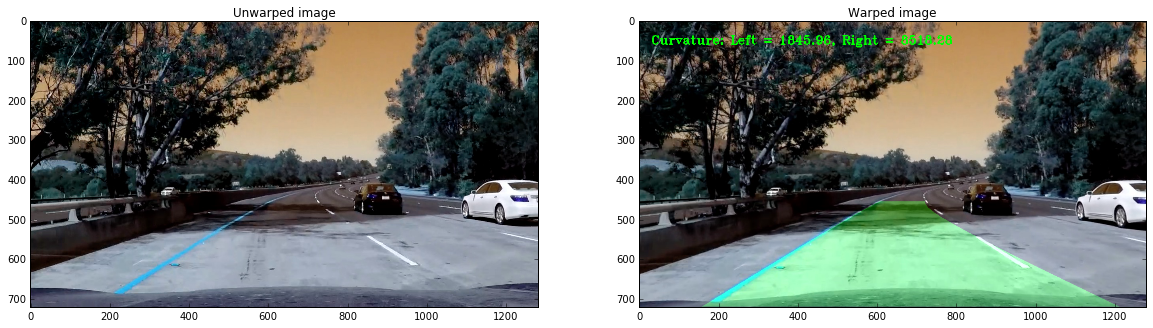

In [111]:
# test the pipeline on test images
image_raw_test = cv2.imread(os.getcwd() + '\\test_images\\test5.jpg')
filter_size = 10
old_img_lines = None
l_fit_buffer = None
r_fit_buffer = None

if image_raw_test.shape[0] != 720:
    image_raw_test = cv2.resize(image_raw_test,(1280, 720), interpolation = cv2.INTER_CUBIC)

shadow = 0

if shadow == 1:
    thresh_min = 10 
    thresh_max = 120 
    s_thresh_min = 25 
    s_thresh_max = 35 
else:
    thresh_min = 20 #50 
    thresh_max = 100 
    s_thresh_min = 110 #170 
    s_thresh_max = 255  
    
warpedImage_vis = pipeline(image_raw_test, mtx, dist, 5, thresh_min, thresh_max, s_thresh_min, s_thresh_max)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Unwarped image')
ax1.imshow(image_raw_test, cmap="gray")
ax2.set_title('Warped image')
ax2.imshow(warpedImage_vis)
#deviation_text = "Lane deviation from center = {:.2f} m".format(lane_deviation) 
#font = cv2.FONT_HERSHEY_TRIPLEX
#cv2.putText(result, deviation_text, (30, 90), font, 1, (0,255,0), 2)

## 5. test on video files

In [32]:
# helpful functions // To_dos:

# mask the region of interested
# ret = cv2.matchShapes(old_img_lines, binary, 1, 0.0)
# radius = mean value of left and right curvature

In [33]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [34]:
filter_size = 10
old_img_lines = None
l_fit_buffer = None
r_fit_buffer = None
def process_image(image):
    processed_img = pipeline(image, mtx, dist, 7, 25, 100, 110, 255)
    return processed_img


In [36]:
# function copied from first project

white_output = 'video_output/neu.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds

#clip1 = VideoFileClip("test/project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
#NOTE: this function expects color images!!
white_clip = clip1.fl_image(process_image) 
%time white_clip.write_videofile(white_output, audio=False)



[MoviePy] >>>> Building video video_output/neu.mp4
[MoviePy] Writing video video_output/neu.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [00:52<00:00,  9.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_output/neu.mp4 

Wall time: 53.6 s
